# Modeling
# Evaluation Matrix : recall
## ROC 与 AUC
<img src="matrix.png" alt="FAO" width="400" length='400' >
<img src="11.png" alt="FAO" width="690" >

<img src="10.png" alt="FAO" width="690" >

接下来我们考虑ROC曲线图中的四个点和一条线。第一个点，(0,1)，即FPR=0, TPR=1，这意味着FN（false negative）=0，并且FP（false positive）=0。Wow，这是一个完美的分类器，它将所有的样本都正确分类。第二个点，(1,0)，即FPR=1，TPR=0，类似地分析可以发现这是一个最糟糕的分类器，因为它成功避开了所有的正确答案。第三个点，(0,0)，即FPR=TPR=0，即FP（false positive）=TP（true positive）=0，可以发现该分类器预测所有的样本都为负样本（negative）。类似的，第四个点（1,1），分类器实际上预测所有的样本都为正样本。经过以上的分析，我们可以断言，ROC曲线越接近左上角，该分类器的性能越好。

下面考虑ROC曲线图中的虚线y=x上的点。这条对角线上的点其实表示的是一个采用随机猜测策略的分类器的结果，例如(0.5,0.5)，表示该分类器随机对于一半的样本猜测其为正样本，另外一半的样本为负样本。

AUC（Area Under Curve）被定义为ROC曲线下的面积，显然这个面积的数值不会大于1。又由于ROC曲线一般都处于y=x这条直线的上方，所以AUC的取值范围在0.5和1之间。使用AUC值作为评价标准是因为很多时候ROC曲线并不能清晰的说明哪个分类器的效果更好，而作为一个数值，对应AUC更大的分类器效果更好。

##  Import cleaned data

In [40]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

# set random seed to reproducibility
np.random.seed(9397)

In [21]:
data_path = os.path.join(os.getcwd(),'data')
train = pd.read_csv(os.path.join(data_path, "train.csv"))
train2 = pd.read_csv(os.path.join(data_path, "train_resample.csv"))
test = pd.read_csv(os.path.join(data_path, "test.csv"))

In [22]:
# seperate features and response
# X_train, Y_train = train.iloc[:,1:], train["loan_status"] 
X_train, Y_train = train2.iloc[:,1:], train2["loan_status"] 
X_test, Y_test = test.iloc[:,1:], test["loan_status"] 

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score
def show_result(clf, X_train, Y_train, X_test, Y_test, pos_label):
    print("Accuracy on train set: {}".format(clf.score(X_train, Y_train)))
    print("Accuracy on test set: {}".format(clf.score(X_test, Y_test)))
    
    plot_confusion_matrix(clf, X_test, Y_test,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 #normalize=normalize
                     )
    Y_pred = clf.predict(X_test)
    Matrix = confusion_matrix(Y_test, Y_pred)
    
    # calculate the result of classification
    result = pd.DataFrame([[-1,-1,-1,-1]],columns=["Accuracy", "Precision", "Recall", "F1-Score"])
    result["Accuracy"] = accuracy_score(Y_test, Y_pred)
    result["Precision"] = precision_score(Y_test, Y_pred, pos_label = pos_label)
    result["Recall"] = recall_score(Y_test, Y_pred, pos_label = pos_label)
    result["F1-Score"] = f1_score(Y_test, Y_pred, pos_label = pos_label)
    return result

def get_roc_curve(clf, X_train, Y_train, X_test, Y_test):
    p = clf.predict_proba(X_test)[:,1]
    return roc_auc_score(Y_test, p)
    

In [39]:
get_roc_curve(clf_logistic,X_train,Y_train,X_test,Y_test)

0.6186875832620604

## 2. logistic regression


In [30]:
clf_logistic.predict_log_proba(X_test)

array([[0.37212735, 0.62787265],
       [0.51370657, 0.48629343],
       [0.49056022, 0.50943978],
       ...,
       [0.56574486, 0.43425514],
       [0.48690042, 0.51309958],
       [0.71658208, 0.28341792]])

(7957, 14)

Accuracy on train set: 0.5896247064910256
Accuracy on test set: 0.523941183863265


,Accuracy,Precision,Recall,F1-Score
0,0.523941,0.903684,0.500875,0.64452


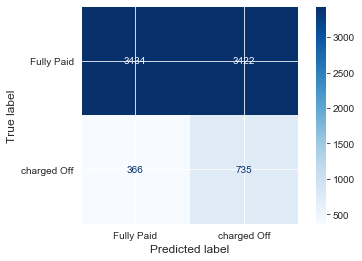

In [24]:
clf_logistic = LogisticRegression(n_jobs = -1).fit(X_train, Y_train)
show_result(clf_logistic,X_train,Y_train,X_test,Y_test, "Fully Paid")

## 3.Decision Tree

Accuracy on train set: 1.0
Accuracy on test set: 0.7164760588161367


,Accuracy,Precision,Recall,F1-Score
0,0.716476,0.871567,0.786902,0.827073


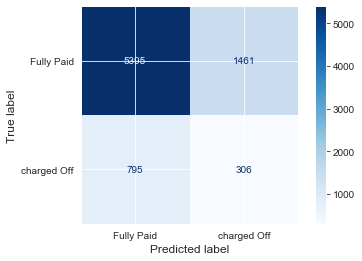

In [26]:
from sklearn import tree
clf_decisionTree = tree.DecisionTreeClassifier()
clf_decisionTree = clf_decisionTree.fit(X_train, Y_train)
show_result(clf_decisionTree,X_train,Y_train,X_test,Y_test,"Fully Paid")

## 4. Random Forest

Accuracy on train set: 1.0
Accuracy on test set: 0.8265678019354028


,Accuracy,Precision,Recall,F1-Score
0,0.826568,0.8702,0.93874,0.903171


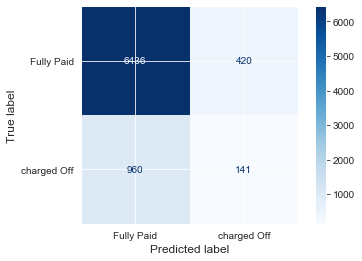

In [27]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_jobs = -1)
clf_rf.fit(X_train,Y_train)
show_result(clf_rf,X_train,Y_train,X_test,Y_test,"Fully Paid")

In [95]:
sum(Y_test == 1)/len(Y_test)

0.861631268065854

In [ ]:
clf_rf.